- [Logistic Regression](#logistic-regression)
- [LSTM](#LSTM)
- [GloVe](#GloVe)
- [BERT](#BERT)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from IPython.display import HTML, display
%matplotlib inline

#### read data

In [2]:
data_dir = ''
labeled_file = 'labeled_5000.csv'

In [3]:
labeled_tweets = pd.read_csv(data_dir + labeled_file, dtype={'tweet_id': str, 'user_id': str})
labeled_tweets.head(2)

,tweet_id,user_id,user_screen_name,user_location,tweet_time,text,tweet_place_type,tweet_place_name,tweet_lat,tweet_lon,FL_tweet,label
0,908320755267633152,878812612972208128,123sheesh,"Palm Beach, FL",2017-09-14 13:25:18,Leaving Palm beach had fun wit the family time...,NaN,NaN,NaN,NaN,True,neutral
1,906601171116273665,293673877,1tymefl,lehigh acres Fl,2017-09-09 19:32:17,"I am not in an evacuation Zone, this is my pre...",NaN,NaN,NaN,NaN,True,negative


In [4]:
labeled_tweets.label.value_counts()

neutral     2006
positive    1727
negative    1267
Name: label, dtype: int64

In [5]:
print(len(set(labeled_tweets[labeled_tweets.label == 'neutral'].user_screen_name)))
print(len(set(labeled_tweets[labeled_tweets.label == 'positive'].user_screen_name)))
print(len(set(labeled_tweets[labeled_tweets.label == 'negative'].user_screen_name)))
print(len(set(labeled_tweets.user_screen_name)))

1871
1504
1163
4332


#### tokenize

In [6]:
import re
from emoji_function import demojize
import string

def tokenize(text, lower=True, neg_hack=False):
    text = demojize(str(text))
    if lower:
        text = text.lower()
    text = re.sub(r'#(\S+)', r'HASHTAG_\1', text)
    text = re.sub(r'@(\S+)', r'MENTION_\1', text)
    text = re.sub(r'http\S+', ' ', text) # ignore url
    text = re.sub(r'(.)\1\1\1+', r'\1', text) # collapse repeating characters
    text = re.sub(r'[0-9]+', '9', text) # collapse numbers
    if neg_hack:
        text = re.sub(r'\b((ai|are|were|have|can?|[wd]o|\w+[sd]|)?n[o\']?t) +(\w+)\b', r'NOT_\3', text) # negation hack
    toks = [t.strip(string.punctuation).strip() for t in text.split()]
    toks = [t for t in toks if len(t) > 0]
    return ' '.join(toks)

#### vectorize

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def featurize(tweets, tfidf=False):
    vec = CountVectorizer(min_df=2, max_df=.5, ngram_range=(1, 2), token_pattern=r'(?u)\b\w+\'?\w+\b', lowercase=False, binary=True)
    if tfidf:
        vec = TfidfVectorizer(min_df=2, max_df=.5, ngram_range=(1, 2), token_pattern=r'(?u)\b\w+\'?\w+\b', lowercase=False, sublinear_tf=True)
    metas = []

    X = vec.fit_transform(tokenize(twt.text, neg_hack=True) for i, twt in tqdm(tweets.iterrows())
                          if not metas.append(dict(user=twt.user_screen_name, time=twt.tweet_time, label=twt.label)))
    y = np.array([m['label'] for m in metas])
    return X, y, vec, metas

#### logistic regression

In [155]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

def print_top_terms(clf, vec, n=50):
    feats = np.array(vec.get_feature_names())
    if len(clf.classes_) == 2:
        coefs = [-clf.coef_[0], clf.coef_[0]]
    else:
        coefs = clf.coef_
    for li, label in enumerate(clf.classes_):
        print('\nclass %s' % label)
        coef = coefs[li]
        top_coef_ind = np.argsort(coef)[::-1][:n]
        top_coef_terms = feats[top_coef_ind]
        top_coef = coef[top_coef_ind]
        print('\n'.join(['%s\t%.3f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)]))    

# cv accuracy
def do_cv(X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    truths = y.copy()
    preds = y.copy()
    probas = np.zeros((len(y), 3))
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
    for train, test in cv.split(X, y):
        clf.fit(X[train], y[train])
        preds[test] = clf.predict(X[test])
        truths[test] = y[test]
        probas[test] = clf.predict_proba(X[test])#[:,-1]

    print(Counter(truths))
    print(Counter(preds))
    print(classification_report(truths, preds, target_names=clf.classes_))
    print('auc=%.3f (positive vs others)' % roc_auc_score(truths == 'positive', probas[:,-1]))
    print('auc=%.3f (negative vs others)' % roc_auc_score(truths == 'negative', probas[:,0]))
    print('auc=%.3f (weighted ovr)' % roc_auc_score(truths, probas, average='weighted', multi_class='ovr', labels=clf.classes_))
    return preds, probas

def run_expt(tweets):
    X,y,vec,metas = featurize(tweets)
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X, y)
    print_top_terms(clf, vec, n=50)
    preds, probas = do_cv(X,y)
    return X,y,vec,metas,clf,preds,probas

def tweets_before_landfall(tweets):
    return tweets[tweets.tweet_time < '2017-09-10 13:00:00']

In [156]:
def run_expt_(tweets):
    X,y,vec,metas = featurize(tweets)
    preds, probas = do_cv(X, y)

In [167]:
run_expt_(labeled_tweets.iloc[:5000])

5000it [00:01, 2825.30it/s]


Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'positive': 1833, 'neutral': 1809, 'negative': 1358})
              precision    recall  f1-score   support

    negative       0.79      0.85      0.82      1267
     neutral       0.81      0.73      0.77      2006
    positive       0.78      0.83      0.81      1727

    accuracy                           0.79      5000
   macro avg       0.79      0.80      0.80      5000
weighted avg       0.79      0.79      0.79      5000

auc=0.922 (positive vs others)
auc=0.951 (negative vs others)
auc=0.913 (weighted ovr)


In [27]:
X,y,vec,metas,clf,preds,probas = run_expt(labeled_tweets)

5000it [00:01, 2742.55it/s]



class negative
NOT_evacuating	2.618
NOT_leaving	2.335
NOT_evacuate	2.326
NOT_fucking leaving	2.214
supplies	2.104
NOT_fucking	2.083
i'm staying	1.592
im	1.456
staying	1.391
we	1.368
i'm NOT_evacuating	1.294
i'm	1.273
NOT_leaving florida	1.248
NOT_think	1.235
NOT_leave my	1.216
NOT_in	1.189
NOT_leave	1.149
glad NOT_leave	1.148
in my	1.126
next	1.118
no	1.093
NOT_think we're	1.063
fam	1.052
we NOT_leave	1.026
friends are	1.019
am	1.017
here	0.986
that's why	0.974
that we	0.973
of my	0.970
board	0.963
fuck	0.953
we're staying	0.945
family	0.943
NOT_go	0.937
HASHTAG_floridastrong	0.925
way i'm	0.876
NOT_leave i'm	0.847
leave so	0.839
NOT_evacuate either	0.839
curfew	0.836
ride	0.832
emoji_loudly_crying_face emoji_loudly_crying_face	0.823
we NOT_evacuate	0.821
evacuating so	0.811
secure	0.810
stay	0.808
hurricane i'm	0.807
we're	0.804
storm i'm	0.796

class neutral
alone	1.470
is evacuating	1.408
leave	1.368
they	1.363
if	1.362
about evacuating	1.350
county	1.346
NOT_leave me	1.190
whole	1

In [126]:
X,y,vec,metas,clf,preds,probas = run_expt(tweets_before_landfall(labeled_tweets))

4138it [00:01, 2670.80it/s]



class negative
NOT_evacuating	2.456
NOT_leaving	2.407
NOT_evacuate	2.256
NOT_fucking leaving	2.124
supplies	2.027
NOT_fucking	1.991
i'm	1.393
i'm NOT_evacuating	1.382
i'm staying	1.368
staying	1.355
NOT_leave	1.263
we	1.223
im	1.219
NOT_think	1.208
we NOT_leave	1.180
NOT_leave my	1.166
NOT_in	1.165
NOT_leaving florida	1.143
of my	1.063
no	1.042
NOT_think we're	1.018
for me	0.991
am	0.987
yes	0.962
in my	0.942
next	0.940
my home	0.938
board	0.936
HASHTAG_floridastrong	0.927
fam	0.927
friends are	0.921
fuck	0.918
we're	0.915
here	0.914
way i'm	0.882
emoji_loudly_crying_face emoji_loudly_crying_face	0.875
hurricane i'm	0.863
family	0.843
we're staying	0.834
that we	0.830
NOT_evacuate either	0.817
leave so	0.808
gonna	0.804
secure	0.796
stay	0.796
im NOT_evacuating	0.778
dogs	0.771
evacuating so	0.770
staying put	0.767
after	0.766

class neutral
alone	1.522
if	1.489
about evacuating	1.337
is evacuating	1.315
they	1.307
or	1.171
girl	1.158
leave	1.150
if we	1.121
county	1.116
families	1.09

tf-idf
```
Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'positive': 1882, 'neutral': 1787, 'negative': 1331})
              precision    recall  f1-score   support

    negative       0.79      0.83      0.81      1267
     neutral       0.81      0.72      0.76      2006
    positive       0.78      0.85      0.81      1727

    accuracy                           0.79      5000
   macro avg       0.79      0.80      0.80      5000
weighted avg       0.80      0.79      0.79      5000

auc=0.916 (weighted ovr)
```
tf-idf before landfall
```
Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1746, 'negative': 1196, 'neutral': 1196})
              precision    recall  f1-score   support

    negative       0.80      0.85      0.83      1126
     neutral       0.79      0.66      0.72      1434
    positive       0.79      0.87      0.83      1578

    accuracy                           0.79      4138
   macro avg       0.80      0.80      0.79      4138
weighted avg       0.79      0.79      0.79      4138

auc=0.918 (weighted ovr)
```

In [131]:
def fommatted_text(text):
    mo = re.search(r'\b(evacuat|leav|escap)(e|ing)\b', text.lower())
    start, end = mo.span()
    text = re.sub('\n', '<br>', f'{text[:start]}<b>{text[start:end]}</b>{text[end:]}')
    return HTML(text)

def series2df(series):
    return pd.DataFrame({idx: [val] for idx, val in zip(series.index, series.values)}, index=[series.name])

def indices_of_top_false_positives(ytrue, ypred, yprob, labels, label='positve'):
    lidx = labels.index(label)
    indices = np.arange(len(ytrue))[(ypred == label) & (ytrue != label)]
    return sorted(indices, key=lambda i: yprob[i, lidx], reverse=True)

In [132]:
false_preds = {}
for label in clf.classes_:
    indices = indices_of_top_false_positives(y, preds, probas, list(clf.classes_), label)
    false_preds[label] = indices
    fp_tweets = tweets_before_landfall(labeled_tweets).iloc[indices].copy() ## labeled_tweets
    fp_tweets['probability'] = probas[indices, list(clf.classes_).index(label)]
    print(f'\n\n{len(fp_tweets)} false {label} tweets')
    for idx, tweet in fp_tweets.iloc[-20:].iterrows():
        display(series2df(tweet)[['tweet_time', 'user_screen_name', 'user_location', 'tweet_place_name', 'label', 'probability']])
        display(fommatted_text(tweet.text))



238 false negative tweets


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4979,2017-09-09 14:18:58,dezidoesit,Miami,NaN,neutral,0.508534


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1292,2017-09-08 14:41:01,chchChillMyNill,"Miami, FL",NaN,neutral,0.507151


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2483,2017-09-07 17:50:01,thedayofsteve,"Orlando, FL",NaN,neutral,0.505041


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2300,2017-09-09 04:43:15,dreamingstar213,Florida,NaN,neutral,0.504982


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
843,2017-09-09 18:59:38,Cheech51111,"FT. LAUDERDALE, FL",NaN,neutral,0.500281


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4914,2017-09-08 15:10:23,_stephlovexo,"Miami, FL",NaN,positive,0.500043


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
522,2017-09-08 21:26:06,40QuinnVulcano,FL,NaN,neutral,0.497812


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4786,2017-09-05 16:56:47,_lordnicholas,"Miami, FL",NaN,neutral,0.492135


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4840,2017-09-09 14:13:12,holstersniffer,"Florida, USA",NaN,neutral,0.483906


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4466,2017-09-08 03:18:31,JennyBoohx3,NaN,NaN,positive,0.478962


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3723,2017-09-05 21:34:45,bre_rico,NaN,NaN,positive,0.465001


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1988,2017-09-06 21:23:30,ProfessorOats,"Boca Raton, FL",NaN,positive,0.460949


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1089,2017-09-08 12:41:37,Kossuel,Florida,NaN,neutral,0.454789


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
814,2017-09-07 21:32:13,CastroFranes,"Florida, USA",NaN,neutral,0.448569


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1877,2017-09-08 02:07:27,MCATDT15,"Bluffton, SC","Florida, USA",positive,0.444617


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2660,2017-09-06 10:22:13,MarcTheFader,"Florida, USA",NaN,neutral,0.399046


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4894,2017-09-07 06:22:22,medproretired,"Florida, USA",NaN,neutral,0.390474


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1142,2017-09-05 18:28:47,OhSoLiveLISA,"Tampa, FL",NaN,neutral,0.372432


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1876,2017-09-06 23:45:33,M3lanyRosario,NaN,NaN,positive,0.362479


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2560,2017-09-09 15:23:25,DebraHobson7,"Florida, USA",NaN,positive,0.345808




265 false neutral tweets


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1023,2017-09-05 23:41:09,Gabi_Vivi,"Florida, USA",NaN,positive,0.505308


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
12,2017-09-10 00:48:17,AimsEconomics,"Tampa, FL","Florida, USA",positive,0.504721


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2040,2017-09-07 00:32:11,Carollagunass,"Fort Myers, FL",NaN,positive,0.502799


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3753,2017-09-08 18:31:32,Danikinssx3,"Miami, FL",NaN,negative,0.502422


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2095,2017-09-05 18:53:26,JelianMercado,"Miami, FL",NaN,positive,0.502203


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
454,2017-09-09 20:57:12,RacingLady88,"Fort Myers, FL",NaN,positive,0.497757


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1588,2017-09-06 12:00:53,BriannaMosley_,"West Palm Beach, FL",NaN,positive,0.497658


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2326,2017-09-09 13:28:53,hellonwheelz84,"Near Sarasota, FL",NaN,positive,0.496667


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4859,2017-09-07 05:44:17,tb_agent0,"Marco Island, FL",NaN,negative,0.496423


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2120,2017-09-07 03:32:39,LadyBeccaBeauty,"Florida, USA",NaN,positive,0.495853


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1095,2017-09-09 12:42:43,LauraLeeBordas,Florida,NaN,negative,0.495264


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1246,2017-09-09 13:05:38,aerose99,"Melbourne, FL",NaN,negative,0.495199


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2728,2017-09-09 15:45:36,TB_MikeB,"Wesley Chapel, FL",NaN,positive,0.486759


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1648,2017-09-05 12:19:00,DJ_TONEKAPONE,"Orlando, FL",NaN,positive,0.482402


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
239,2017-09-09 15:52:53,JT_Evans97,NaN,NaN,positive,0.477112


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2357,2017-09-07 20:12:56,karenellen45,Florida's Space Coast,"South Patrick Shores, FL",positive,0.476732


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
143,2017-09-09 13:05:06,David3oh5,NaN,NaN,positive,0.471609


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2901,2017-09-08 20:19:04,kikacol,"Treasure Coast, Florida",NaN,negative,0.44554


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1742,2017-09-06 23:42:23,HBJaguar,718 to 609 to 904 to 407,NaN,positive,0.437421


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2437,2017-09-05 15:12:40,rachelking237,"Tampa, FL",NaN,positive,0.43009




333 false positive tweets


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1836,2017-09-08 16:04:05,KristenLickens,"Tampa, Orlando & ✈ me to you",NaN,neutral,0.513448


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
354,2017-09-07 13:55:37,MT_Cassidy,"Fort Myers, FL",NaN,neutral,0.509953


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2433,2017-09-07 02:48:46,princessria_,"Miami, FL",NaN,neutral,0.509895


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2777,2017-09-05 19:52:17,_yevelys_,"Miami, FL",NaN,neutral,0.509871


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
608,2017-09-07 00:08:02,AngelCurras1,"Florida, USA",NaN,negative,0.507803


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3483,2017-09-08 03:28:46,Leeam_E,"Miami, FL",NaN,neutral,0.507737


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3559,2017-09-08 20:19:00,Meagan__6661,"Daytona Beach, FL",NaN,negative,0.506208


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2887,2017-09-04 22:59:53,jmkjor,"Orlando, FL",NaN,neutral,0.501871


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2337,2017-09-08 19:42:37,incenseoakley,florida,NaN,negative,0.499041


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
1797,2017-09-07 21:43:20,Jsajem,"Miami, FL",NaN,negative,0.498794


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2018,2017-09-06 21:44:39,AshleyFaithxx3,"Miami, FL",NaN,neutral,0.497812


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
89,2017-09-07 19:19:15,CWELCHNC,NaN,"Orlando, FL",neutral,0.496522


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3713,2017-09-08 03:05:42,jstmejeff,"Orlando, FL",NaN,negative,0.49599


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2689,2017-09-06 15:06:33,Qu3Qa09,"Fort Lauderdale, FL",NaN,neutral,0.494895


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3725,2017-09-06 21:32:58,_thegoatgoat,"University, FL","University, FL",neutral,0.484429


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2794,2017-09-09 19:35:50,autumncarterx,"Florida, USA",NaN,neutral,0.483153


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
3851,2017-09-08 20:24:32,karen_rummy,"Thonotosassa, FL",NaN,negative,0.478771


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
2909,2017-09-06 07:35:44,laurathomsonx,Paisley,NaN,neutral,0.454338


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
433,2017-09-08 07:35:14,Only1DaniNicole,"Florida, USA",NaN,neutral,0.426388


,tweet_time,user_screen_name,user_location,tweet_place_name,label,probability
4943,2017-09-05 03:00:48,sanctifyer1,"Florida, USA",NaN,neutral,0.383771


### LSTM

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [9]:
import tensorflow as tf
#import tensorflow.keras.backend as K
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#K.tensorflow_backend.set_session(tf.Session(config=config))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [149]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, MaxPooling1D
from keras.models import Model
from keras.optimizers import Adam

def get_samples(tweets, neg_hack=True, min_df=4):
    tokenizer = Tokenizer(filters='', lower=False, oov_token='OOV')
    tweet_texts = [tokenize(txt, neg_hack=neg_hack) for txt in tweets.text]
    tokenizer.fit_on_texts(tweet_texts)
    print('%s unique tokens' % len(tokenizer.word_index))
    tokenizer.num_words = sum(df >= min_df for df in tokenizer.word_docs.values()) # min_df
    print('%d terms preserved' % tokenizer.num_words)
    
    X_seq = tokenizer.texts_to_sequences(tweet_texts)
    lens = [len(seq) for seq in X_seq]
    print('sequence length from %d to %d' % (min(lens), max(lens)))
    X_pad = pad_sequences(X_seq, padding="pre")
    
    dummies = pd.get_dummies(tweets.label)
    Y = dummies.values
    classes = dummies.columns.values
    return X_pad, Y, classes, tokenizer

def get_model(
    input_length,
    output_length,
    vocab_size, # embedding layer input_dim
    embedding_dim=32,
    filters=64,
    ksize=5,
    psize=3,
    lstm_units=32
):
    x = Input((input_length,), name="input")
    e = Embedding(vocab_size, embedding_dim)(x)
    c = Conv1D(filters=filters, kernel_size=ksize, padding='same', activation='relu')(e)
    p = MaxPooling1D(pool_size=psize)(c)
    l = LSTM(lstm_units)(p)
    y = Dense(output_length, activation='softmax' if output_length > 1 else 'sigmoid')(l)
    
    model = Model(x, y)
    model.compile(loss='categorical_crossentropy' if output_length > 1 else 'binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

def cross_validation(X, Y, labels, tokenizer, **kwargs):
    class_weight = {i: len(Y) / num / 3 for i, num in enumerate(np.sum(Y, axis=0))}
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    truths = labels[np.argmax(Y, axis=1)]
    probas = np.zeros((len(Y), 3))
    for train, test in tqdm(cv.split(X, truths)):
        clf = get_model(X.shape[-1], 3, tokenizer.num_words, **kwargs)
        h = clf.fit(X[train], Y[train], epochs=5, verbose=0, class_weight=class_weight)
        probas[test] = clf.predict(X[test])
    preds = labels[np.argmax(probas, axis=1)]

    print(Counter(truths))
    print(Counter(preds))
    print(classification_report(truths, preds, target_names=labels))
    #print('auc=%.3f (positive vs others)' % roc_auc_score(truths == 'positive', probas[:,-1]))
    print('auc=%.3f (weighted ovr)' % roc_auc_score(truths, probas, average='weighted', multi_class='ovr', labels=labels))
    return preds, probas

def run_lstm(tweets):
    X, Y, classes, tokenizer = get_samples(tweets)
    preds, probas = cross_validation(X, Y, classes, tokenizer)

In [48]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def simple_train(X, Y, model, class_weight=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    if class_weight == 'balanced':
        class_weight = {i: len(Y) / num / 3 for i, num in enumerate(np.sum(Y, axis=0))}
        print(class_weight)
    history = model.fit(X_train, Y_train, epochs=20, validation_split=0.2, class_weight=class_weight,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    scores = model.evaluate(X_test, Y_test)
    print('\n'.join([f'{met}: {val}' for met, val in zip(['loss', 'acc'], scores)]))
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

def run_pretest(tweets):
    X, Y, classes, tokenizer = get_samples(tweets)
    lstm = get_model(X.shape[-1], 3, tokenizer.num_words, embedding_dim=32, filters=64, lstm_units=32)
    simple_train(X, Y, lstm, 'balanced')

In [58]:
run_lstm(labeled_tweets)

0it [00:00, ?it/s]

10017 unique tokens
1692 terms preserved
sequence length from 1 to 79


10it [03:53, 23.34s/it]

Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'neutral': 1856, 'positive': 1744, 'negative': 1400})
              precision    recall  f1-score   support

    negative       0.72      0.79      0.76      1267
     neutral       0.76      0.70      0.73      2006
    positive       0.76      0.77      0.77      1727

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000

auc=0.886 (weighted ovr)


In [59]:
run_lstm(tweets_before_landfall(labeled_tweets))

0it [00:00, ?it/s]

8468 unique tokens
1474 terms preserved
sequence length from 1 to 79


10it [03:32, 21.22s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1546, 'neutral': 1374, 'negative': 1218})
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78      1126
     neutral       0.71      0.68      0.69      1434
    positive       0.79      0.78      0.78      1578

    accuracy                           0.75      4138
   macro avg       0.75      0.75      0.75      4138
weighted avg       0.75      0.75      0.75      4138

auc=0.887 (weighted ovr)


In [62]:
run_lstm(labeled_tweets) # with negation_hack

0it [00:00, ?it/s]

10287 unique tokens
1712 terms preserved
sequence length from 1 to 78


10it [05:04, 30.44s/it]

Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'neutral': 1883, 'positive': 1739, 'negative': 1378})
              precision    recall  f1-score   support

    negative       0.74      0.80      0.77      1267
     neutral       0.75      0.70      0.72      2006
    positive       0.76      0.77      0.76      1727

    accuracy                           0.75      5000
   macro avg       0.75      0.76      0.75      5000
weighted avg       0.75      0.75      0.75      5000

auc=0.887 (weighted ovr)


In [61]:
run_lstm(tweets_before_landfall(labeled_tweets)) # with negation_hack

0it [00:00, ?it/s]

8700 unique tokens
1486 terms preserved
sequence length from 1 to 78


10it [04:01, 24.18s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1644, 'neutral': 1331, 'negative': 1163})
              precision    recall  f1-score   support

    negative       0.77      0.80      0.78      1126
     neutral       0.72      0.66      0.69      1434
    positive       0.79      0.82      0.80      1578

    accuracy                           0.76      4138
   macro avg       0.76      0.76      0.76      4138
weighted avg       0.76      0.76      0.76      4138

auc=0.893 (weighted ovr)


In [65]:
run_lstm(labeled_tweets) # with negation_hack, no conv

0it [00:00, ?it/s]

10287 unique tokens
1712 terms preserved
sequence length from 1 to 78


10it [12:07, 72.76s/it]

Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'positive': 1860, 'neutral': 1700, 'negative': 1440})
              precision    recall  f1-score   support

    negative       0.73      0.84      0.78      1267
     neutral       0.78      0.67      0.72      2006
    positive       0.75      0.81      0.78      1727

    accuracy                           0.76      5000
   macro avg       0.76      0.77      0.76      5000
weighted avg       0.76      0.76      0.76      5000

auc=0.888 (weighted ovr)


In [64]:
run_lstm(tweets_before_landfall(labeled_tweets)) # with negation_hack, no conv

0it [00:00, ?it/s]

8700 unique tokens
1486 terms preserved
sequence length from 1 to 78


10it [10:01, 60.10s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1629, 'neutral': 1260, 'negative': 1249})
              precision    recall  f1-score   support

    negative       0.76      0.84      0.80      1126
     neutral       0.74      0.65      0.69      1434
    positive       0.79      0.82      0.80      1578

    accuracy                           0.76      4138
   macro avg       0.76      0.77      0.76      4138
weighted avg       0.76      0.76      0.76      4138

auc=0.890 (weighted ovr)


### GloVe

In [142]:
glove_file = 'glove.twitter.27B.200d.txt'

In [143]:
word2vec = {}
with open(glove_file, encoding='utf8') as file:
    for line in tqdm(file):
        records = line.split()
        word2vec[records[0]] = np.asarray(records[1:], dtype='float32')

1193514it [00:54, 21834.81it/s]


In [144]:
def get_embedding_matrix(tokenizer, word_vecs, d=200):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, d))
    for word, index in tokenizer.word_index.items():
        if word in word_vecs:
            embedding_matrix[index] = word_vecs[word]
    return embedding_matrix

In [118]:
from keras.layers import Flatten

class LSTMModel:
    
    def __init__(self, 
        input_shape,
        output_len,
        embedding_matrix,
        n_filters=64,
        lstm_units=32
    ):
        self.input_shape = input_shape
        self.output_len = output_len
        self.embedding_matrix = embedding_matrix
        self.n_filters = n_filters
        self.lstm_units = lstm_units
        self._build_model()
    
    def clear(self):
        K.clear_session()
    
    def _build_model(self):
        x_input = Input(shape=self.input_shape)
        in_dim, out_dim = self.embedding_matrix.shape
        embedding = Embedding(in_dim, out_dim, weights=[self.embedding_matrix], input_length=self.input_shape[0], trainable=False)(x_input)
        conv = Conv1D(filters=self.n_filters, kernel_size=5, padding='same', activation='relu')(embedding)
        pooling = MaxPooling1D(pool_size=3)(conv)
        #flatten = Flatten()(pooling)
        lstm = LSTM(self.lstm_units)(pooling)
        output = Dense(self.output_len, activation='softmax' if self.output_len > 1 else 'sigmoid')(lstm)
        
        self.model = Model(inputs=x_input, outputs=output)
        
        self.model.compile(loss='categorical_crossentropy' if self.output_len > 1 else 'binary_crossentropy', 
                           optimizer='adam', metrics=['accuracy'])

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def predict(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)

def cv_glove(X, Y, labels, embedding_mat, **kwargs):
    class_weight = {i: len(Y) / num / 3 for i, num in enumerate(np.sum(Y, axis=0))}
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    truths = labels[np.argmax(Y, axis=1)]
    probas = np.zeros((len(Y), 3))
    for train, test in tqdm(cv.split(X, truths)):
        clf = LSTMModel(X.shape[1:], Y.shape[1], embedding_mat)
        clf.fit(X[train], Y[train], epochs=6, verbose=0, class_weight=class_weight)
        probas[test] = clf.predict(X[test])
        clf.clear()
    preds = labels[np.argmax(probas, axis=1)]

    print(Counter(truths))
    print(Counter(preds))
    print(classification_report(truths, preds, target_names=labels))
    print('auc=%.3f (weighted ovr)' % roc_auc_score(truths, probas, average='weighted', multi_class='ovr', labels=labels))
    return preds, probas

def run_glove(tweets, word_vecs):
    X, Y, classes, tokenizer = get_samples(tweets, neg_hack=False, min_df=2)
    embedding_mat = get_embedding_matrix(tokenizer, word_vecs)
    preds, probas = cv_glove(X, Y, classes, embedding_mat)

In [114]:
def pretest_glove(X, Y, model, class_weight=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    if class_weight == 'balanced':
        class_weight = {i: len(Y) / num / 3 for i, num in enumerate(np.sum(Y, axis=0))}
    history = model.fit(X_train, Y_train, epochs=20, validation_split=0.2, class_weight=class_weight,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    scores = model.evaluate(X_test, Y_test)
    print('\n'.join([f'{met}: {val}' for met, val in zip(['loss', 'acc'], scores)]))
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

def run_pretest_glove(tweets, word_vecs):
    X, Y, classes, tokenizer = get_samples(tweets, neg_hack=False, min_df=2)
    embedding_mat = get_embedding_matrix(tokenizer, word_vecs)
    lstm = LSTMModel(X.shape[1:], Y.shape[1], embedding_mat, n_filters=64, lstm_units=64)
    pretest_glove(X, Y, lstm, 'balanced')

10017 unique tokens
3170 terms preserved
sequence length from 1 to 79
Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 6s 2ms/step - loss: 0.9547 - accuracy: 0.5350 - val_loss: 0.8648 - val_accuracy: 0.6288
Epoch 2/20
3200/3200 [==============================] - 3s 951us/step - loss: 0.7126 - accuracy: 0.6862 - val_loss: 0.7451 - val_accuracy: 0.7063
Epoch 3/20
3200/3200 [==============================] - 3s 1ms/step - loss: 0.5685 - accuracy: 0.7650 - val_loss: 0.7245 - val_accuracy: 0.7063
Epoch 4/20
3200/3200 [==============================] - 3s 892us/step - loss: 0.4458 - accuracy: 0.8197 - val_loss: 0.7262 - val_accuracy: 0.7100
Epoch 5/20
3200/3200 [==============================] - 3s 1ms/step - loss: 0.3496 - accuracy: 0.8497 - val_loss: 0.7976 - val_accuracy: 0.7138
Epoch 6/20
1000/1000 [==============================] - 1s 558us/step
loss: 0.882515018939972
acc: 0.6940000057220459


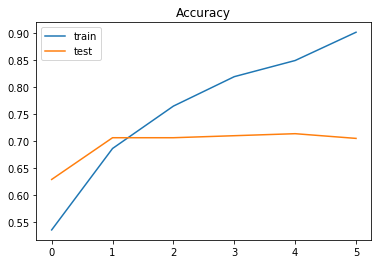

In [117]:
run_pretest_glove(labeled_tweets, word2vec) # 64, 64

10017 unique tokens
10016 terms preserved
sequence length from 1 to 79
5490
Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 6s 2ms/step - loss: 0.9834 - accuracy: 0.5050 - val_loss: 0.9153 - val_accuracy: 0.6325
Epoch 2/20
3200/3200 [==============================] - 3s 898us/step - loss: 0.7129 - accuracy: 0.6988 - val_loss: 0.6850 - val_accuracy: 0.7262
Epoch 3/20
3200/3200 [==============================] - 3s 1ms/step - loss: 0.5420 - accuracy: 0.7747 - val_loss: 0.6622 - val_accuracy: 0.7225
Epoch 4/20
3200/3200 [==============================] - 3s 976us/step - loss: 0.4096 - accuracy: 0.8384 - val_loss: 0.6647 - val_accuracy: 0.7350
Epoch 5/20
3200/3200 [==============================] - 3s 867us/step - loss: 0.2940 - accuracy: 0.8869 - val_loss: 0.7264 - val_accuracy: 0.7475
Epoch 6/20
1000/1000 [==============================] - 0s 492us/step
loss: 0.907120491027832
acc: 0.699999988079071


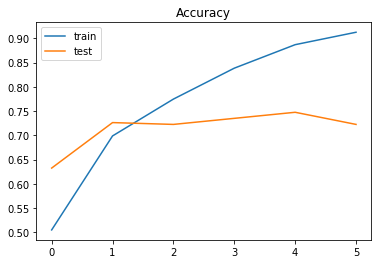

In [109]:
run_pretest_glove(labeled_tweets, word2vec)

In [119]:
run_glove(labeled_tweets, word2vec)

0it [00:00, ?it/s]

10017 unique tokens
3170 terms preserved
sequence length from 1 to 79


10it [04:56, 29.70s/it]


Counter({'neutral': 2006, 'positive': 1727, 'negative': 1267})
Counter({'positive': 1893, 'neutral': 1841, 'negative': 1266})
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      1267
     neutral       0.75      0.69      0.72      2006
    positive       0.73      0.80      0.77      1727

    accuracy                           0.74      5000
   macro avg       0.73      0.74      0.73      5000
weighted avg       0.74      0.74      0.73      5000

auc=0.878 (weighted ovr)


In [123]:
run_glove(tweets_before_landfall(labeled_tweets), word2vec) # 100d

0it [00:00, ?it/s]

8468 unique tokens
2733 terms preserved
sequence length from 1 to 79


10it [03:33, 21.33s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1608, 'neutral': 1285, 'negative': 1245})
              precision    recall  f1-score   support

    negative       0.71      0.78      0.74      1126
     neutral       0.68      0.61      0.65      1434
    positive       0.77      0.78      0.77      1578

    accuracy                           0.72      4138
   macro avg       0.72      0.73      0.72      4138
weighted avg       0.72      0.72      0.72      4138

auc=0.876 (weighted ovr)


In [137]:
run_glove(tweets_before_landfall(labeled_tweets), word2vec) # 50d

0it [00:00, ?it/s]

8468 unique tokens
2733 terms preserved
sequence length from 1 to 79


10it [03:37, 21.79s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1591, 'negative': 1348, 'neutral': 1199})
              precision    recall  f1-score   support

    negative       0.64      0.77      0.70      1126
     neutral       0.68      0.57      0.62      1434
    positive       0.77      0.78      0.78      1578

    accuracy                           0.70      4138
   macro avg       0.70      0.71      0.70      4138
weighted avg       0.71      0.70      0.70      4138

auc=0.862 (weighted ovr)


In [145]:
run_glove(tweets_before_landfall(labeled_tweets), word2vec) # 200d

0it [00:00, ?it/s]

8468 unique tokens
2733 terms preserved
sequence length from 1 to 79


10it [03:38, 21.88s/it]

Counter({'positive': 1578, 'neutral': 1434, 'negative': 1126})
Counter({'positive': 1633, 'neutral': 1371, 'negative': 1134})
              precision    recall  f1-score   support

    negative       0.74      0.75      0.75      1126
     neutral       0.70      0.67      0.69      1434
    positive       0.79      0.81      0.80      1578

    accuracy                           0.75      4138
   macro avg       0.74      0.74      0.74      4138
weighted avg       0.74      0.75      0.75      4138

auc=0.889 (weighted ovr)
